In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from p_tqdm import p_map
import os, sys
from functools import reduce

In [19]:
def implicit_rates(
    in_path,
    out_path,
    recipe,
    quantiles,
    pulse_year,
    eta=2.0,
    rho=0.0,
    disc='euler_ramsey',
    hue=['quantile'],
    title=None,
    rff=True,
    sel_dict=None,
):
    
    if rff == True:
        factors = xr.open_zarr(f"{in_path}/{recipe}_{disc}_eta{eta}_rho{rho}_uncollapsed_discount_factors.zarr").mean('simulation')
        factors = factors.quantile(quantiles, 'rff_sp').discount_factor
    else:
        factors = xr.open_dataset(f"{in_path}/{recipe}_{disc}_eta{eta}_rho{rho}_discount_factors.nc4").discount_factors

    subset = factors.sel(sel_dict).rename('discfac').to_dataframe().reset_index().sort_values('weitzman_parameter')

    subset["rate"] = (1 / subset.discfac) ** (
        1 / (subset.year - pulse_year)
    ) - 1
    
    subset['hue'] = reduce(
    lambda  a,b: pd.Series.add(a,b),
    [subset[i] for i in hue])


    g = sns.relplot(data=subset.reset_index(),
                x='year',
                y='rate',
                hue='hue',
                legend='full',
                kind='line',
                col='weitzman_parameter',
                col_wrap=3
               )

    g.fig.suptitle(f"{title}, {sector}, discount rates for RFF simulations")

    os.makedirs(f"{out_path}/", exist_ok=True)
    plt.savefig(f"{out_path}/rff-{rff}_{title}_{sector}_discount_rates.png", bbox_to_inches='tight', dpi=300)

In [24]:
sector = 'AMEL_clipped'
quantiles = [0, 0.005, 0.01, 0.05, 0.5, 0.95, 0.99, 0.995, 1]
pulse_year = 2020
recipe='risk_aversion'
disc='euler_ramsey'

/tmp/ipykernel_2853863/1827391425.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{out_path}/rff-{rff}_{title}_{sector}_discount_factors.png", bbox_to_inches='tight', dpi=300)


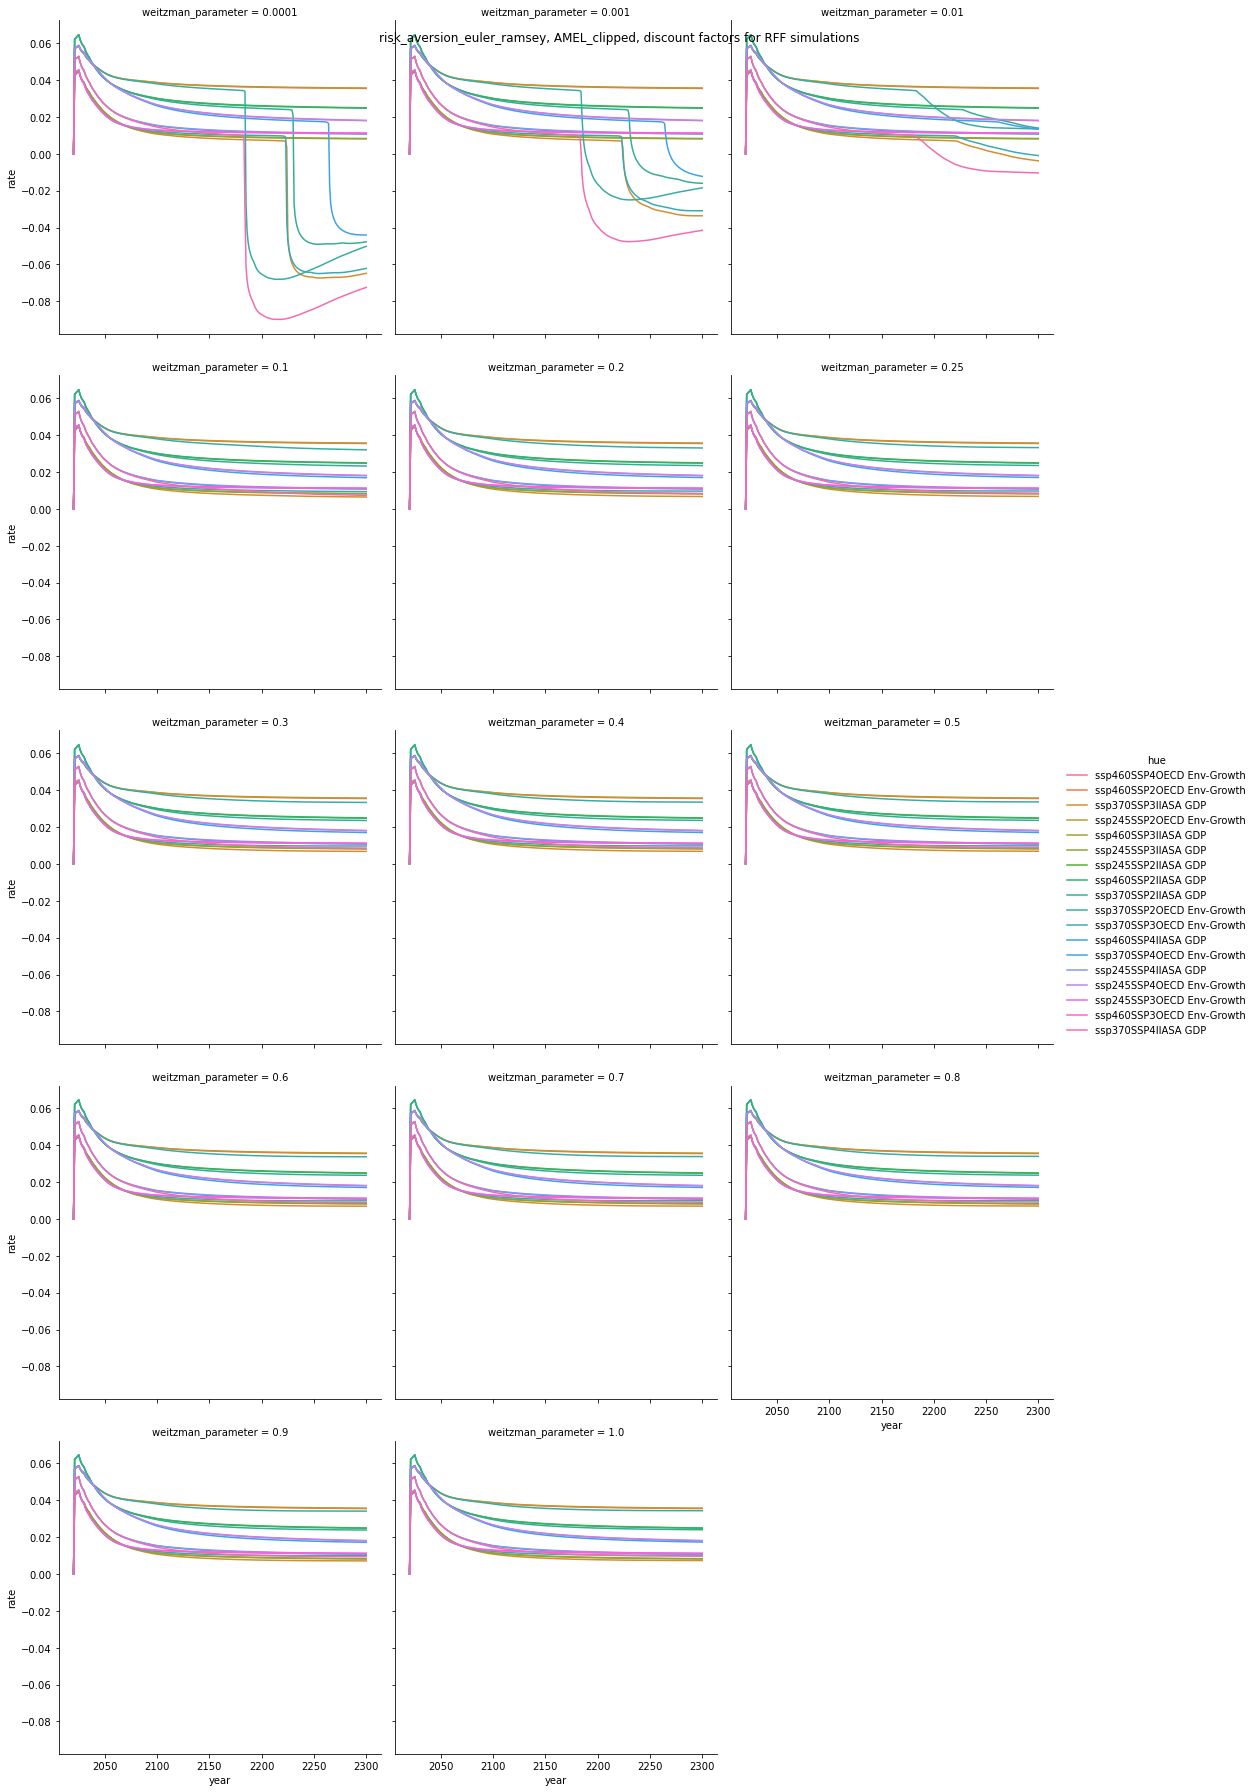

In [25]:
rff=False

implicit_rates(
    in_path=f"/mnt/CIL_integration/menu_results_AR6_bc39_epa_vsl_continuous/{sector}/{pulse_year}/unmasked",
    out_path=f"/mnt/CIL_integration/rff_diagnostics/discount_factors/",
    recipe=recipe,
    eta=2.0,
    rho=0.0,
    disc=disc,
    title=f"{recipe}_{disc}",
    pulse_year=pulse_year,
    quantiles=quantiles,
    rff=rff,
    sel_dict=dict(fair_aggregation='ce'),
    hue=['rcp', 'ssp', 'model'],
)

/tmp/ipykernel_2853863/1827391425.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f"{out_path}/rff-{rff}_{title}_{sector}_discount_factors.png", bbox_to_inches='tight', dpi=300)


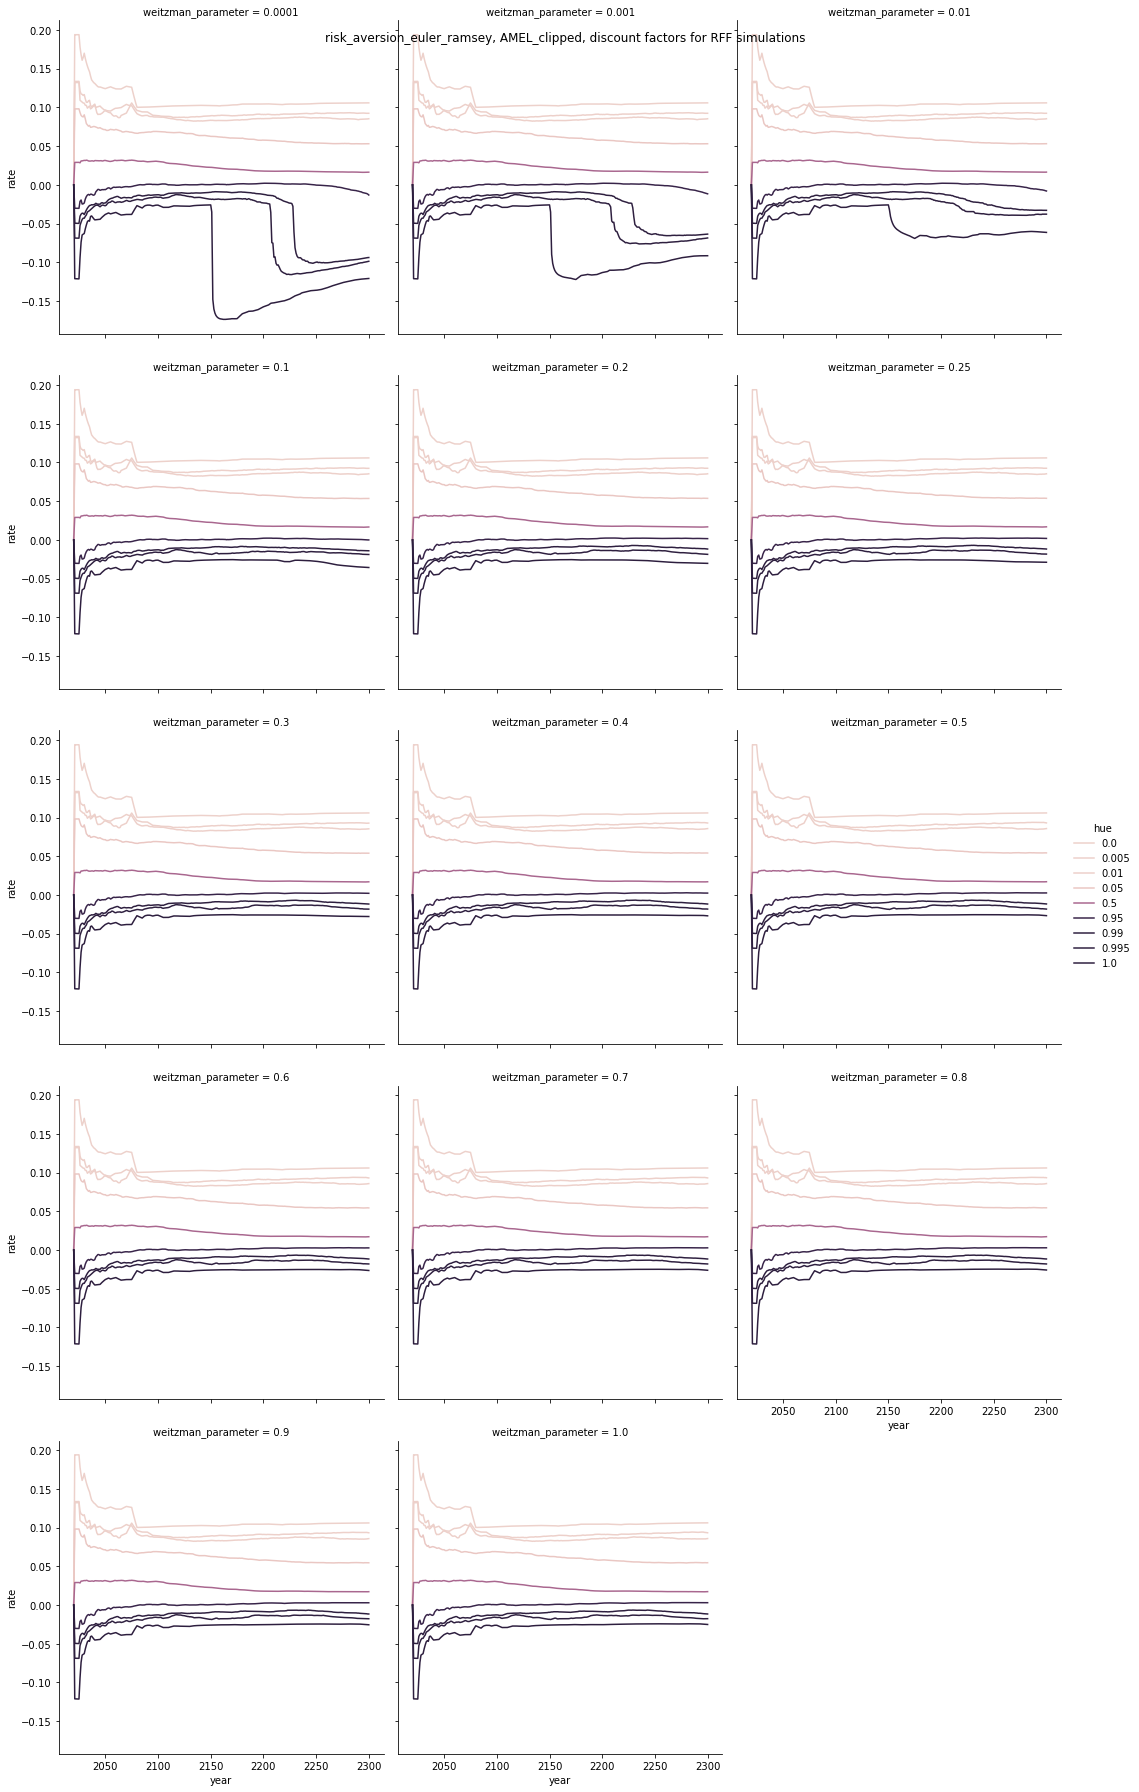

In [26]:
rff=True

implicit_rates(
    in_path=f"/mnt/CIL_integration/rff3_with_disc_factors/iter0-19/{sector}/{pulse_year}/unmasked_None/",
    out_path=f"/mnt/CIL_integration/rff_diagnostics/discount_factors",
    recipe=recipe,
    eta=2.0,
    rho=0.0,
    disc=disc,
    title=f"{recipe}_{disc}",
    pulse_year=pulse_year,
    quantiles=quantiles,
    rff=rff
)